In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import scipy.stats as st

In [3]:
# Requires LaTeX installed locally in the computer
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

**Data source:** ERA5 C3S/ECMWF. [Link for tabular data](https://climate.copernicus.eu/sites/default/files/custom-uploads/2402%20CB/PR_fig3_timeseries_era5_2t_daily_anomalies_relative_to_preindustrial_1940-2024.csv). The original gridded ERA5 hourly data used to generate the time series can be downloaded from the C3S Climate Data Store (CDS) at [https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels)

**Description:** This file contains daily mean 2m temperature data from ERA5 averaged over the entire globe (90°S - 90°N, 0 - 360° E)

**Method:** The general method used to estimate the change relative to predindustrial is described in the following web article: https://climate.copernicus.eu/tracking-breaches-150c-global-warming-threshold.

**Final vs preliminary data:** The last value in the time series may be preliminary in which case it will likely change (slightly) once the final data for the day are available (typically 3 days behind real-time). The difference between the preliminary and final values is generally very small.

**Columns:**
- temp: Daily mean absolute temperature based on hourly values from 00 to 23 UTC
- clim_91-20: Daily temperature climatology for 1991-2020
- ano_91-20: Daily temperature anomaly relative to 1991-2020
- offset_pi: Daily offset between the 1850-1900 average and the 1991-2020 average
- ano_pi: Best estimate of the temperature change relative to preindustrial level (1850-1900). ano_pi = ano_91-20 + offset_pi
- status: Status of the daily average temperature (preliminary or final)

**Units:** Degrees Celsius

**Last updated:** 06 Mar 2024

In [4]:
df = pd.read_csv("Data/era5_daily_sfc_temp_global_anomalies_ref1850-1900_1940-2024.csv", skiprows = 14)

In [5]:
df.head(5)

,date,temp,clim_91-20,ano_91-20,offset_pi,ano_pi,status
0,1940-01-01,11.72,12.48,-0.76,0.95,0.19,FINAL
1,1940-01-02,11.66,12.47,-0.81,0.95,0.14,FINAL
2,1940-01-03,11.66,12.47,-0.80,0.95,0.15,FINAL
3,1940-01-04,11.68,12.46,-0.78,0.95,0.17,FINAL
4,1940-01-05,11.60,12.45,-0.85,0.95,0.10,FINAL


In [6]:
df.tail(3)

,date,temp,clim_91-20,ano_91-20,offset_pi,ano_pi,status
30741,2024-03-01,13.50,13.00,0.50,0.96,1.46,FINAL
30742,2024-03-02,13.64,13.03,0.62,0.96,1.57,FINAL
30743,2024-03-03,13.72,13.05,0.67,0.96,1.63,PRELIMINARY


In [7]:
#https://en.m.wikipedia.org/wiki/File:20180522_Color_palette_for_warming_stripes_-_ColorBrewer_9-class_single_hue.svg
IPCC_colors = ["#08306b", "#08519c", "#2171b5", "#4292c6", "#6baed6", "#9ecae1",
               "#c6dbef", "#deebf7", "#fee0d2", "#fcbba1", "#fc9272", "#fb6a4a",
               "#ef3b2c", "#cb181d", "#a50f15", "#67000d"]
IPCC_cmap = mpl.colors.LinearSegmentedColormap.from_list("", IPCC_colors)

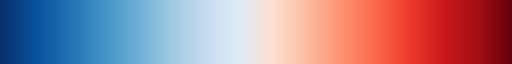

In [8]:
IPCC_cmap

**Kernel density estimator** for smoothing temperature distributions ([more here](https://en.wikipedia.org/wiki/Kernel_density_estimation)).

Each data point $x_i$ is substituted by a guassian kernel with width $h$.

\begin{align}
    k(y) = \frac{1}{\sqrt{2 \pi}} \exp{\left(-\frac{y^2}{2} \right)}
\end{align}

where

$$ y = \frac{x - x_i}{h} $$

In [9]:
def kernel(x, xi, h):
    y = (x - xi)/h
    k = (1/np.sqrt(2*np.pi)) * np.exp(-y**2 / 2)
    return k

# 1991 - 2020 Average

100%|██████████| 85/85 [00:09<00:00,  9.39it/s]


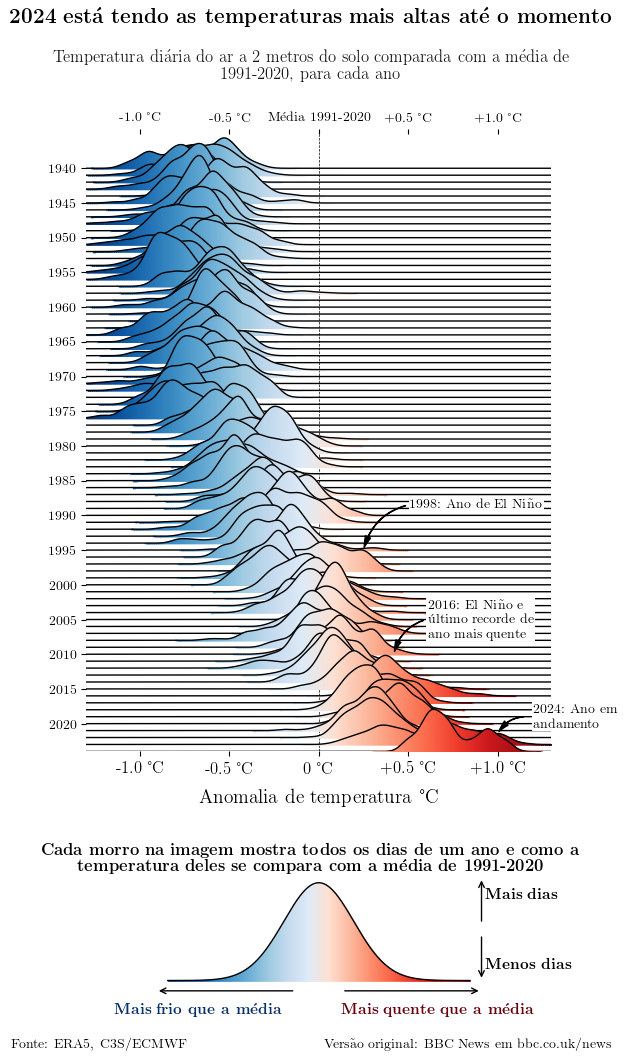

In [10]:
# Plot specifications
fig, ax = plt.subplots(2, 1, figsize = (6,11), gridspec_kw = {'height_ratios': [6,1],
                                                             'hspace': 0.35})

x = np.linspace(-1.3, 1.3, 1000)
h = 0.04 # Kernel width

# Loop for plotting each distribution from 1940 to 2024
for i in tqdm(range(1940,2025)):
    # Selects a subset of the dataframe corresponding only to the i-th year
    df_new = df.loc[(df['date'] >= f'{i}-01-01') & (df['date'] < f'{i+1}-01-01')].reset_index(drop = True)
    
    # Adds the kernel density for each j-th day in the year
    k = 0
    for j in range(len(df_new)):
        k += kernel(x, df_new['ano_91-20'][j], h)
    
    # Fills the kernel density curve with the IPCC colormap
    for j in range(IPCC_cmap.N):
        xi = x[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]
        if np.max(k[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]/(len(df_new)*h)) >= 1e-5:
            ax[0].fill_between(xi, -i, 2*k[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]/(len(df_new)*h) - i,
                             color = IPCC_cmap(j), zorder = 2*(i-1940))
    
    # Plots the kernel density shape in black
    ax[0].plot(x, 2*k/(len(df_new)*h) - i, color = 'black', lw = 1, zorder = 2*(i-1940)+1)
    
# Adds the 0 temperature anomaly line for reference
ax[0].axvline(0, lw = 0.5, color = 'black', ls = '--', zorder = 0)
# Customization of x-axis
ax[0].set_xlim(-1.3, 1.3)
ax[0].set_xticks([-1,-0.5,0,0.5,1])
ax[0].set_xticklabels(labels = ['-1.0 °C','-0.5 °C','0 °C','+0.5 °C','+1.0 °C'], fontsize = 12)
ax[0].set_xlabel('Anomalia de temperatura °C', fontsize = 14, labelpad = 10)
# Customization of y-axis
ax[0].set_ylim(-2024, -1935)
ax[0].set_yticks([-i for i in range(1940, 2025, 5)])
ax[0].set_yticklabels(labels = [i for i in range(1940, 2025, 5)])

# Clones the x-axis to add other ticks on top of the graph
ax3 = ax[0].twiny()
# Customization of second x-axis
ax3.set_xlim(-1.3, 1.3)
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticklabels(labels = ['-1.0 °C','-0.5 °C','Média 1991-2020','+0.5 °C','+1.0 °C'], fontsize = 10)

# Title
fig.text(0.5, 0.98, r'\bf{2024 está tendo as temperaturas mais altas até o momento}',
         ha = 'center', fontsize = 15)
# Subtitle
fig.text(0.5, 0.93, 'Temperatura diária do ar a 2 metros do solo comparada com a média de \n1991-2020, para cada ano',
         ha = 'center', fontsize = 12, color = 'black', alpha = 0.9)
# Lower text
fig.text(0.5, 0.21, r'\bf{Cada morro na imagem mostra todos os dias de um ano e como a}'
         '\n'
         r'\bf{temperatura deles se compara com a média de 1991-2020}',
         ha = 'center', fontsize = 12)

# Removing frame from plots
ax[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax3.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Plots normal curve on second plot
ax[1].plot(x, st.norm.pdf(x, 0, 0.3), lw = 1, color = 'black')
# Fills the curve with the IPCC colormap
for j in range(IPCC_cmap.N):
    xi = x[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]
    if np.max(st.norm.pdf(x, 0, 0.3)) >= 1e-5:
        ax[1].fill_between(xi, 0, st.norm.pdf(xi, 0, 0.3),
                         color = IPCC_cmap(j))
# Setting axis limits
ax[1].set_xlim(-2, 2)
ax[1].set_ylim(0, 1.4)
ax[1].axis('off')
# Arrows
ax[1].annotate('', xy=(0.55, -0.1), xycoords='axes fraction', xytext=(0.85, -0.1), 
            arrowprops=dict(arrowstyle="<-", color='black'))
ax[1].annotate('', xy=(0.15, -0.1), xycoords='axes fraction', xytext=(0.45, -0.1), 
            arrowprops=dict(arrowstyle="->", color='black'))

ax[1].annotate('', xy=(0.85, 0), xycoords='axes fraction', xytext=(0.85, 0.45), 
            arrowprops=dict(arrowstyle="->", color='black'))
ax[1].annotate('', xy=(0.85, 0.55), xycoords='axes fraction', xytext=(0.85, 1), 
            arrowprops=dict(arrowstyle="<-", color='black'))
# Texts
fig.text(0.55, 0.08, r'\bf{Mais quente que a média}', color = IPCC_cmap(255), fontsize = 11)
fig.text(0.45, 0.08, r'\bf{Mais frio que a média}', color = IPCC_cmap(0), fontsize = 11,
        ha = 'right')

fig.text(0.79, 0.184, r'\bf{Mais dias}', color = 'black', fontsize = 11)
fig.text(0.79, 0.12, r'\bf{Menos dias}', color = 'black', fontsize = 11)

# Add source and credits text
fig.text(0, 0.05, 'Fonte: ERA5, C3S/ECMWF', color = 'black', fontsize = 10)
fig.text(1, 0.05, 'Versão original: BBC News em bbc.co.uk/news', color = 'black', fontsize = 10,
        ha = 'right')

# Curved arrows in main plot
style = "Simple, tail_width=0.2, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((1.16, -2019), (1, -2021.5),
                             connectionstyle="arc3,rad=.3", **kw)
a2 = patches.FancyArrowPatch((0.6, -2005), (0.42, -2010),
                             connectionstyle="arc3,rad=.3", **kw)
a3 = patches.FancyArrowPatch((0.5, -1988.5), (0.25, -1995),
                             connectionstyle="arc3,rad=.3", **kw)

for a in [a1,a2,a3]:
    plt.gca().add_patch(a)
    
# Texts in main plot
plt.text(1.2, -2019, '2024: Ano em \nandamento', va = 'center', bbox = dict(facecolor = 'white', alpha = 1,
                                                        edgecolor = 'none', boxstyle = 'square,pad=0.1'))
plt.text(0.61, -2005, '2016: El Niño e \núltimo recorde de \nano mais quente', va = 'center', bbox = dict(facecolor = 'white', alpha = 1,
                                                        edgecolor = 'none', boxstyle = 'square,pad=0.1'))
plt.text(0.51, -1988.5, '1998: Ano de El Niño', va = 'center', bbox = dict(facecolor = 'white', alpha = 1,
                                                        edgecolor = 'none', boxstyle = 'square,pad=0.1'))
    
# Save figure
plt.savefig('Plots/BBC_daily_temperature_distribution_years_1991-2020_reference.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()

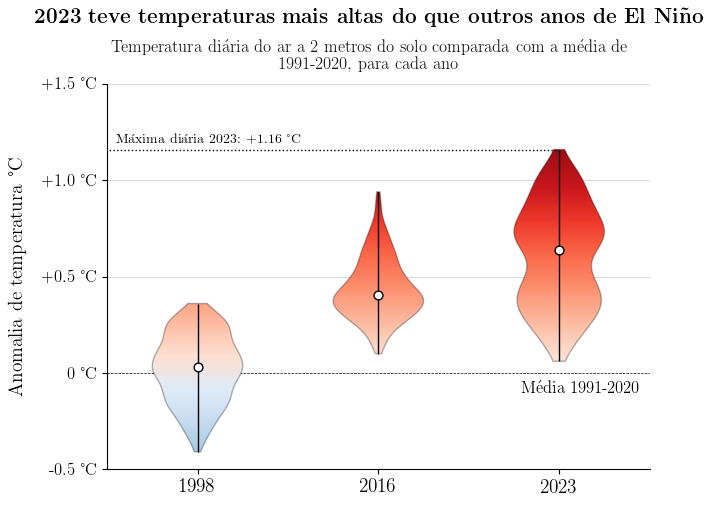

In [11]:
# Plot specifications
fig, ax = plt.subplots(1, 1, figsize = (7,5))

# Axis limits for cmap figure
ymin, ymax = -1.3, 1.3
xmin, xmax = -0.5, 2.5

# Create array for inserting colormap fill inside violinplots
Nx,Ny=1,1000
imgArr = np.tile(np.linspace(0,1,Ny), (Nx,1)).T

# Getting daily temperature data for each of the last three El Niño years
years = []
for idx, key in enumerate([1998,2016,2023]):
    df_new = df.loc[(df['date'] >= f'{key}-01-01') & (df['date'] < f'{key+1}-01-01')].reset_index(drop = True)
    years.append(df_new['ano_91-20'].values)
    
# Violinplot
parts = ax.violinplot(years, positions = [0,1,2], showextrema = False, showmeans = False)

for i in range(3):
    # Getting quartiles and whiskers from data of each year
    whiskers_min, quartile1, medians, quartile3, whiskers_max = np.percentile(years[i], [0, 25, 50, 75, 100])
    # Plot median temperature for each year
    ax.scatter(i, medians, marker='o', color='white', s=40, zorder=3, edgecolor = 'black')
    # Plot range of data in each year
    ax.vlines(i, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Fill the violinplots
for pc in parts['bodies']:
    pc.set_facecolor('none')
    path = Path(pc.get_paths()[0].vertices)
    patch = PathPatch(path, facecolor='none', edgecolor='none')
    ax.add_patch(patch)
    img = ax.imshow(imgArr, origin="lower", extent=[xmin,xmax,ymin,ymax], aspect="auto",
                    cmap=IPCC_cmap,
                    clip_path=patch)
    
# Maximum temperature anomaly line
plt.hlines(np.max(years[2]), ymin, 2, lw = 1, color = 'black', ls = 'dotted')
# Reference line
ax.axhline(0, lw = 0.5, color = 'black', ls = '--', zorder = 0)

# Grids
ax.axhline(0.5, color = 'grey', alpha = 0.3, zorder = -1, lw = 0.7)
ax.axhline(1, color = 'grey', alpha = 0.3, zorder = -1, lw = 0.7)
ax.axhline(1.5, color = 'grey', alpha = 0.3, zorder = -1, lw = 0.7)

# Axis limites
ax.set_xlim(xmin, xmax)
ax.set_ylim(-0.5, 1.5)
# Axis ticks
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels = [1998,2016,2023], fontsize = 14)
ax.set_yticks([-0.5,0,0.5,1,1.5])
ax.set_yticklabels(labels = ['-0.5 °C','0 °C','+0.5 °C','+1.0 °C','+1.5 °C'], fontsize = 12)
# y-axis label
ax.set_ylabel('Anomalia de temperatura °C', fontsize = 14, labelpad = 10)

# Texts inside plot
plt.text(2.45, -0.05, 'Média 1991-2020', fontsize = 12, va = 'top', ha = 'right')
plt.text(-0.45, np.max(years[2])+0.02, f'Máxima diária 2023: +{np.max(years[2]):.2f} °C', fontsize = 10, va = 'bottom', ha = 'left')


# Texts outside plot
# Subtitle
fig.text(0.5, 0.91, 'Temperatura diária do ar a 2 metros do solo comparada com a média de \n1991-2020, para cada ano',
         ha = 'center', fontsize = 12, color = 'black', alpha = 0.9)
# Title
fig.text(0.5, 1, r'\bf{2023 teve temperaturas mais altas do que outros anos de El Niño}',
         ha = 'center', fontsize = 15)

# Removing top and right frames
ax.spines[['top', 'right']].set_visible(False)

# Save figure
plt.savefig('Plots/2023_daily_temperature_distribution_El_Nino_years.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()

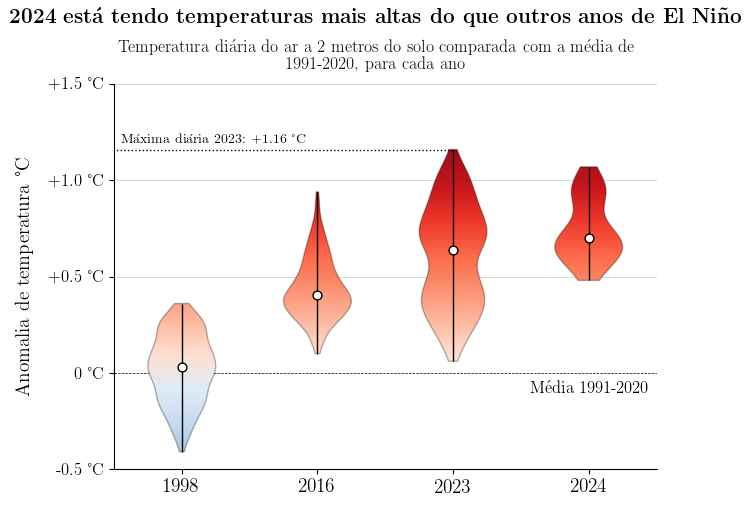

In [12]:
# Plot specifications
fig, ax = plt.subplots(1, 1, figsize = (7,5))

# Axis limits for cmap figure
ymin, ymax = -1.3, 1.3
xmin, xmax = -0.5, 3.5

# Create array for inserting colormap fill inside violinplots
Nx,Ny=1,1000
imgArr = np.tile(np.linspace(0,1,Ny), (Nx,1)).T

# Getting daily temperature data for each of the last three El Niño years
years = []
for idx, key in enumerate([1998,2016,2023,2024]):
    df_new = df.loc[(df['date'] >= f'{key}-01-01') & (df['date'] < f'{key+1}-01-01')].reset_index(drop = True)
    years.append(df_new['ano_91-20'].values)
    
# Violinplot
parts = ax.violinplot(years, positions = [0,1,2,3], showextrema = False, showmeans = False)

for i in range(4):
    # Getting quartiles and whiskers from data of each year
    whiskers_min, quartile1, medians, quartile3, whiskers_max = np.percentile(years[i], [0, 25, 50, 75, 100])
    # Plot median temperature for each year
    ax.scatter(i, medians, marker='o', color='white', s=40, zorder=3, edgecolor = 'black')
    # Plot range of data in each year
    ax.vlines(i, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Fill the violinplots
for pc in parts['bodies']:
    pc.set_facecolor('none')
    path = Path(pc.get_paths()[0].vertices)
    patch = PathPatch(path, facecolor='none', edgecolor='none')
    ax.add_patch(patch)
    img = ax.imshow(imgArr, origin="lower", extent=[xmin,xmax,ymin,ymax], aspect="auto",
                    cmap=IPCC_cmap,
                    clip_path=patch)
    
# Maximum temperature anomaly line
plt.hlines(np.max(years[2]), ymin, 2, lw = 1, color = 'black', ls = 'dotted')
# Reference line
ax.axhline(0, lw = 0.5, color = 'black', ls = '--', zorder = 0)

# Grids
ax.axhline(0.5, color = 'grey', alpha = 0.3, zorder = -1, lw = 0.7)
ax.axhline(1, color = 'grey', alpha = 0.3, zorder = -1, lw = 0.7)
ax.axhline(1.5, color = 'grey', alpha = 0.3, zorder = -1, lw = 0.7)

# Axis limites
ax.set_xlim(xmin, xmax)
ax.set_ylim(-0.5, 1.5)
# Axis ticks
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels = [1998,2016,2023,2024], fontsize = 14)
ax.set_yticks([-0.5,0,0.5,1,1.5])
ax.set_yticklabels(labels = ['-0.5 °C','0 °C','+0.5 °C','+1.0 °C','+1.5 °C'], fontsize = 12)
# y-axis label
ax.set_ylabel('Anomalia de temperatura °C', fontsize = 14, labelpad = 10)

# Texts inside plot
plt.text(3.45, -0.05, 'Média 1991-2020', fontsize = 12, va = 'top', ha = 'right')
plt.text(-0.45, np.max(years[2])+0.02, f'Máxima diária 2023: +{np.max(years[2]):.2f} °C', fontsize = 10, va = 'bottom', ha = 'left')


# Texts outside plot
# Subtitle
fig.text(0.5, 0.91, 'Temperatura diária do ar a 2 metros do solo comparada com a média de \n1991-2020, para cada ano',
         ha = 'center', fontsize = 12, color = 'black', alpha = 0.9)
# Title
fig.text(0.5, 1, r'\bf{2024 está tendo temperaturas mais altas do que outros anos de El Niño}',
         ha = 'center', fontsize = 15)

# Removing top and right frames
ax.spines[['top', 'right']].set_visible(False)

# Save figure
plt.savefig('Plots/2024_daily_temperature_distribution_El_Nino_years.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()

# 1850 - 1900 Average

100%|██████████| 85/85 [00:06<00:00, 12.24it/s]


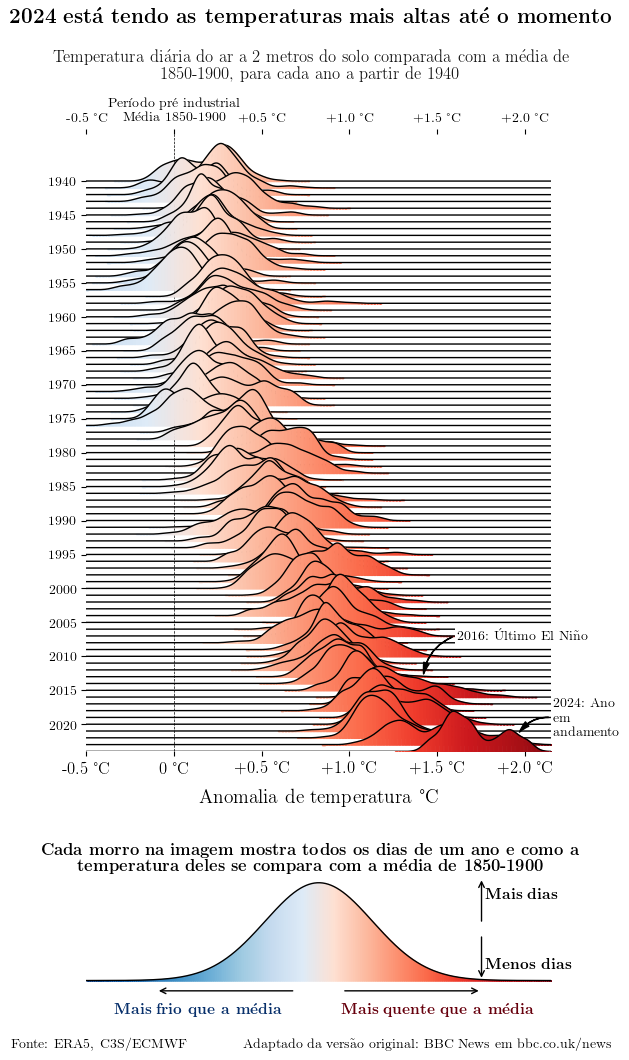

In [13]:
fig, ax = plt.subplots(2, 1, figsize = (6,11), gridspec_kw = {'height_ratios': [6,1],
                                                             'hspace': 0.35})

x = np.linspace(-2.3, 2.3, 1000)
h = 0.04

for i in tqdm(range(1940,2025)):
    df_new = df.loc[(df['date'] >= f'{i}-01-01') & (df['date'] < f'{i+1}-01-01')].reset_index(drop = True)
    
    k = 0
    for j in range(len(df_new)):
        k += kernel(x, df_new['ano_pi'][j], h)
    
    for j in range(IPCC_cmap.N):
        xi = x[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]
        if np.max(k[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]/(len(df_new)*h)) >= 1e-5:
            ax[0].fill_between(xi, -i, 2*k[len(x)*j//IPCC_cmap.N:len(x)*(j+1)//IPCC_cmap.N]/(len(df_new)*h) - i,
                             color = IPCC_cmap(j), zorder = 2*(i-1940))
    
    ax[0].plot(x, 2*k/(len(df_new)*h) - i, color = 'black', lw = 1, zorder = 2*(i-1940)+1)
    
ax[0].axvline(0, lw = 0.5, color = 'black', ls = '--', zorder = 0)
ax[0].set_xlim(-0.5, 2.15)
ax[0].set_ylim(-2024, -1933)
ax[0].set_yticks([-i for i in range(1940, 2025, 5)])
ax[0].set_yticklabels(labels = [i for i in range(1940, 2025, 5)])
ax[0].set_xticks([-0.5,0,0.5,1,1.5,2])
ax[0].set_xticklabels(labels = ['-0.5 °C','0 °C','+0.5 °C','+1.0 °C','+1.5 °C','+2.0 °C'], fontsize = 12)
ax[0].set_xlabel('Anomalia de temperatura °C', fontsize = 14, labelpad = 10)

ax3 = ax[0].twiny()
ax3.set_xlim(-0.5, 2.15)
ax3.set_xticks([-0.5,0,0.5,1,1.5,2])
ax3.set_xticklabels(labels = ['-0.5 °C','Período pré industrial \nMédia 1850-1900','+0.5 °C','+1.0 °C','+1.5 °C','+2.0 °C'], fontsize = 10)

# ax[0].text(0, -1935, 'Média 1991-2020', fontsize = 12, ha = 'center')

fig.text(0.5, 0.93, 'Temperatura diária do ar a 2 metros do solo comparada com a média de \n1850-1900, para cada ano a partir de 1940',
         ha = 'center', fontsize = 12, color = 'black', alpha = 0.9)

fig.text(0.5, 0.98, r'\bf{2024 está tendo as temperaturas mais altas até o momento}',
         ha = 'center', fontsize = 15)

fig.text(0.5, 0.21, r'\bf{Cada morro na imagem mostra todos os dias de um ano e como a}'
         '\n'
         r'\bf{temperatura deles se compara com a média de 1850-1900}',
         ha = 'center', fontsize = 12)

ax[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax3.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

x2 = np.linspace(-1.3, 1.3, 1000)
ax[1].plot(x2, st.norm.pdf(x2, 0, 0.3), lw = 1, color = 'black')
for j in range(IPCC_cmap.N):
    xi = x2[len(x2)*j//IPCC_cmap.N:len(x2)*(j+1)//IPCC_cmap.N]
    if np.max(st.norm.pdf(x2, 0, 0.3)) >= 1e-5:
        ax[1].fill_between(xi, 0, st.norm.pdf(xi, 0, 0.3),
                         color = IPCC_cmap(j))
ax[1].set_xlim(-1.3, 1.3)
ax[1].set_ylim(0, 1.4)
ax[1].axis('off')
ax[1].annotate('', xy=(0.55, -0.1), xycoords='axes fraction', xytext=(0.85, -0.1), 
            arrowprops=dict(arrowstyle="<-", color='black'))
ax[1].annotate('', xy=(0.15, -0.1), xycoords='axes fraction', xytext=(0.45, -0.1), 
            arrowprops=dict(arrowstyle="->", color='black'))
fig.text(0.55, 0.08, r'\bf{Mais quente que a média}', color = IPCC_cmap(255), fontsize = 11)
fig.text(0.45, 0.08, r'\bf{Mais frio que a média}', color = IPCC_cmap(0), fontsize = 11,
        ha = 'right')

ax[1].annotate('', xy=(0.85, 0), xycoords='axes fraction', xytext=(0.85, 0.45), 
            arrowprops=dict(arrowstyle="->", color='black'))
ax[1].annotate('', xy=(0.85, 0.55), xycoords='axes fraction', xytext=(0.85, 1), 
            arrowprops=dict(arrowstyle="<-", color='black'))
fig.text(0.79, 0.184, r'\bf{Mais dias}', color = 'black', fontsize = 11)
fig.text(0.79, 0.12, r'\bf{Menos dias}', color = 'black', fontsize = 11)

fig.text(0, 0.05, 'Fonte: ERA5, C3S/ECMWF', color = 'black', fontsize = 10)
fig.text(1, 0.05, 'Adaptado da versão original: BBC News em bbc.co.uk/news', color = 'black', fontsize = 10,
        ha = 'right')

style = "Simple, tail_width=0.2, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((2.15, -2019), (1.96, -2021.5),
                             connectionstyle="arc3,rad=.3", **kw)
a2 = patches.FancyArrowPatch((1.6, -2007), (1.42, -2013),
                             connectionstyle="arc3,rad=.3", **kw)
plt.text(2.16, -2019, '2024: Ano \nem \nandamento', va = 'center', bbox = dict(facecolor = 'white', alpha = 1,
                                                        edgecolor = 'none', boxstyle = 'square,pad=0.1'))
plt.text(1.61, -2007, '2016: Último El Niño', va = 'center', bbox = dict(facecolor = 'white', alpha = 1,
                                                        edgecolor = 'none', boxstyle = 'square,pad=0.1'))
for a in [a1,a2]:
    plt.gca().add_patch(a)
plt.savefig('Plots/BBC_daily_temperature_distribution_years_1850-1900_reference.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()